In [ ]:
# !pip install wandb -q
# !pip3 install pytorch_lightning torchmetrics -q

In [ ]:
import wandb

wandb.login()

In [ ]:
from collections import defaultdict, namedtuple

import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm

In [ ]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [ ]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True) 

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели. 
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать: 

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали. 
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

In [ ]:
# Подсчитаем средние и стандартные отклонения по трем каналам
train_data = ImageFolder('/content/dataset/dataset/train', transform=transforms.Compose([transforms.ToTensor()]))

means, vars = [], []
for image, label in train_data:
    means.append(image.mean(dim=(1, 2)))
    vars.append(image.std(dim=(1, 2)))
print(f'mean channels: {torch.stack(means).mean(dim=0)}, std channels: {torch.stack(vars).mean(dim=0)}')

mean channels: tensor([0.4802, 0.4481, 0.3975]), std channels: tensor([0.2302, 0.2265, 0.2262])


In [ ]:
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2302, 0.2265, 0.2262))
    ]
)
val_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2302, 0.2265, 0.2262))

    ]
)

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [ ]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

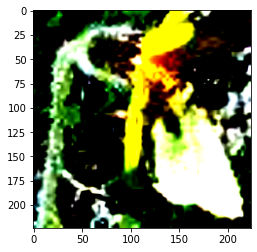

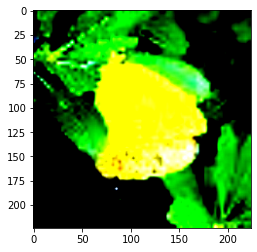

In [ ]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте предобученную)

In [ ]:
# Эксперимент 1
# from torchvision.models import resnet18
# model = resnet18(pretrained=True)

In [ ]:
# Эксперимент 2
# !pip install efficientnet_pytorch
# from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b0')

In [ ]:
# !pip install timm

In [ ]:
# https://www.kaggle.com/code/pdochannel/swin-transformer-in-pytorch
HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"

model = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True)

### Гиперпараметры

In [ ]:
EPOCHS = 5
lr = 0.01

### Тренировочный класс lightning

In [ ]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        in_features = self.model.head.in_features
        self.model.head = nn.Identity()
        self.classifier = nn.Linear(in_features, 200)
        self.learning_rate = learning_rate
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        with torch.no_grad():
            features = self.model(x)
        preds = self.classifier(features)
        return preds

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.classifier.parameters(), lr=self.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=2, gamma=0.5)
        return [self.optimizer], [self.scheduler]

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long())
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

In [ ]:
wandb_logger = WandbLogger(log_model='all')
device = "cuda" if torch.cuda.is_available() else "cpu"

module = YourModule(model, lr)

In [ ]:
lr_monitor = LearningRateMonitor(logging_interval='epoch')
trainer = pl.Trainer(logger=wandb_logger,
                     accelerator="gpu",
                     max_epochs=EPOCHS,
                     callbacks=[lr_monitor])

trainer.fit(module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params
------------------------------------------------
0 | model      | SwinTransformer  | 27.5 M
1 | classifier | Linear           | 153 K 
2 | loss       | CrossEntropyLoss | 0     
------------------------------------------------
27.7 M    Trainable params
0         Non-trainable params
27.7 M    Total params
110.693   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


### Валидация результатов задания

In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    predicted_classes = torch.Tensor([]).to(device)
    true_classes = torch.Tensor([]).to(device)

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images, labels = images.to(device), labels.to(device)

            pred = model.forward(images)
            pred_classes = torch.argmax(pred, dim=-1)

            predicted_classes = torch.cat((predicted_classes, pred_classes), 0)
            true_classes = torch.cat((true_classes, labels), 0)

    return accuracy_score(predicted_classes.cpu().detach().numpy(), true_classes.cpu().detach().numpy())

In [ ]:
# https://github.com/Lightning-AI/lightning/issues/924
def weights_update(model, checkpoint):
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint['state_dict'].items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    return model

model = weights_update(model=module, checkpoint=torch.load('/content/task2_swin_transformer_pretrained_0786'))

In [ ]:
accuracy = evaluate_task(model, val_dataloader)
print(f"\n\nОценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")

100%|██████████| 40/40 [00:49<00:00,  1.23s/it]



Оценка за это задание составит 8.42 баллов


# Отчёт об экспериментах 

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.

https://wandb.ai/dgkomarov_hse/lightning_logs/reports/-2-2--VmlldzoyODc4ODcy?accessToken=zcmhn490c0zn8j1d3p2i2c22wbdtzy1dvt2h8uxka2utcyhbsri9d5yqtnyhsvzt

**Веса модели**: https://drive.google.com/file/d/18-owmDmiS28p07bt8AiMUUsHLVrthu9g/view?usp=sharing